# RL and Advanced DL: Домашнее задание 2

Второе домашнее задание опять посвящено игре; его базовая часть, надеюсь, не слишком большая, но я добавил опциональную часть, которая, думаю, должна быть достаточно интересной для любого слушателя. Как обычно, **в качестве решения ожидается ссылка на jupyter-ноутбук на вашем github (или публичный, или с доступом для snikolenko); ссылку обязательно нужно прислать в виде сданного домашнего задания на портале Академии**. Любые комментарии, новые идеи и рассуждения на тему, как всегда, категорически приветствуются.  
![alt text](hw2_pic.png "Title")

In [1]:
import numpy as np
import random
from collections import defaultdict
from collections.abc import Iterable
from tic_tac_toe import TicTacToe, plot_test_game
import tqdm
import copy
import matplotlib.pyplot as plt

## Часть первая: крестики-нолики при помощи Q-обучения
В коде, прилагающемся к последней лекции про обучение с подкреплением, реализован Environment для крестиков-ноликов, в котором можно при инициализации указывать разные размеры доски и условия победы, а также функции для рисования, в том числе с указанием оценки различных действий. С этим окружением все задания и связаны.
1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.
2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.
**Disclaimer**: начиная с пункта 2, задания для досок размера больше 4х4 могут потребовать большого терпения или более сложных вычислительных реализаций (например, параллелизации). Не хочу в этом задании непременно требовать ни того ни другого, так что если не будет получаться доучить до победных стратегий, не страшно -- но покажите, что со временем что-то всё-таки улучшается.

In [2]:
env = TicTacToe(n_rows=4, n_cols=4, n_win=3)
# plot_test_game(env, None, None, random_crosses=True, random_naughts=True, verbose=True, fontx=60)

Создадим классы для случайной и eps-жадной политик

In [3]:
class RandomPolicy:
    def __init__(self):
        pass
    
    def get_action(self, state):
        _, empty_spaces, _ = state
        action_idx = np.random.randint(len(empty_spaces))
        return action_idx

In [4]:
class EpsGreedyPolicy:
    def __init__(self, eps=0.):
        self.Q = {}
        self.eps = eps

    def get_action(self, state):
        board_hash, empty_spaces, _ = state
        
        if board_hash not in self.Q:
            self.Q[board_hash] = np.zeros(len(empty_spaces))

        if random.random() >= self.eps:
            action_idx = np.argmax(self.Q[board_hash])
        else:
            action_idx = np.random.randint(len(empty_spaces))
        
        return action_idx

Функция играющая один эпизод

In [5]:
def run_episode(env, policies: dict):
    env.reset()
    state = env.getState()
    _, empty_spaces, curr_turn = state
    # states, rewards, actions = [], [], []
    done = False
    
    while not done:
        action_idx = policies[curr_turn].get_action(state)
        action = empty_spaces[action_idx]
        # states.append(observation)
        # actions.append(action)
        state, reward, done, _ = env.step(action)
        _, empty_spaces, curr_turn = state
        # rewards.append(reward)

    return reward

Средняя награда за epoch эпизодов

In [6]:
def avg_reward(env, policies: dict, epochs=1000, verbose=True):
    crosses_wins = 0
    naughts_wins = 0
    draws = 0
    cnt = 0
    for _ in tqdm.tqdm(range(epochs), disable=not verbose):
        cnt += 1
        reward = run_episode(env, policies)
        if reward == 1:
            crosses_wins += 1
        elif reward == -1:
            naughts_wins += 1
        else:
            draws += 1 

    return crosses_wins / cnt, naughts_wins / cnt, draws / cnt

Самая простая реализация Q-learning для игр с противником:
1. Считаем действия и ходы противника частью среды
2. Если обучаем нолики, то домножаем награду на -1 (вместо этого можно было еще max(Q) заменить на min)

In [7]:
def Q_learning_episode(env, policies: dict, alpha=0.1, gamma=0.9, train_first_policy=True):
    done = False
    env.reset()
    state = env.getState()
    board_hash, empty_spaces, curr_turn = state
    side = 1
    
    # if we want to train naughts
    if not train_first_policy:
        action_idx = policies[curr_turn].get_action(state)
        action = empty_spaces[action_idx]
        state, reward, done, _ = env.step(action)
        board_hash, empty_spaces, curr_turn = state
        # reverse reward
        side = -1
    
    while not done:
        action_idx = policies[curr_turn].get_action(state)
        action = empty_spaces[action_idx]
        state_prime, reward, done, _ = env.step(action)
        reward *= side
        if not done:
            # enemy action
            _, enemy_empty_spaces, enemy_curr_turn = state_prime
            enemy_action_idx = policies[enemy_curr_turn].get_action(state_prime)
            action = enemy_empty_spaces[enemy_action_idx]
            state_prime, reward, done, _ = env.step(action)
            reward *= side
            
        board_hash_prime, _, _ = state_prime
        
        max_next_Q = (
            np.max(policies[curr_turn].Q[board_hash_prime])
            if board_hash_prime in policies[curr_turn].Q
            else 0.
        )
        
        policies[curr_turn].Q[board_hash][action_idx] += alpha * (
            reward + gamma * max_next_Q
            - policies[curr_turn].Q[board_hash][action_idx]
        )
        
        state = state_prime
        board_hash, empty_spaces, curr_turn = state
        

    return policies

In [8]:
%%timeit
bool(random.getrandbits(1))

108 ns ± 3.71 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [9]:
%%timeit
random.choice([True, False])

344 ns ± 7.1 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


Будем случайным образом обучать то одну стратегию, то другую  
Валидировать обе стратегии будем на случайной стратегии

In [10]:
def Q_learning(
    env, policies: dict, eval_policy=RandomPolicy(), 
    alpha=0.05, gamma=0.9,
    eps_init=0.9, eps_final=0.01, 
    eps_decay=2_000, evaluate_every=1_000,
    avg_reward_epochs=1000,
    epochs=20000, verbose=True
):
    
    crosses_history = {
        "crosses_win_rate": [],
        "noughts_win_rate": [],
        "draws_win_rate": [],
        "iteration": []
    }
    
    noughts_history = copy.deepcopy(crosses_history)
    
    for n in tqdm.tqdm(range(epochs), disable=not verbose):
        
        eps = eps_init + (eps_final - eps_init) * n / eps_decay
        for key in policies:
            policies[key].eps = eps
        
        # randomly choose policy for Q-learning
        train_first_policy = bool(random.getrandbits(1))
        policies = Q_learning_episode(
            env, policies, alpha=alpha, gamma=gamma,
            train_first_policy=train_first_policy
        )
        
        if n % evaluate_every == 0:
            crosses, noughts, draws = avg_reward(
                env, {1: policies[1], -1: eval_policy}, 
                epochs=avg_reward_epochs, verbose=verbose
            )
            crosses_history["crosses_win_rate"].append(crosses)
            crosses_history["noughts_win_rate"].append(noughts)
            crosses_history["draws_win_rate"].append(draws)
            crosses_history["iteration"].append(n)
            
            crosses, noughts, draws = avg_reward(
                env, {-1: policies[-1], 1: eval_policy},
                epochs=avg_reward_epochs, verbose=verbose
            )
            noughts_history["crosses_win_rate"].append(crosses)
            noughts_history["noughts_win_rate"].append(noughts)
            noughts_history["draws_win_rate"].append(draws)
            noughts_history["iteration"].append(n)

    return policies, crosses_history, noughts_history

In [11]:
def plot_history(history, fontsize: int = 16, figsize: tuple = (12, 6)):
    plt.figure(figsize=figsize)
    plt.title("Average winrate", fontsize=fontsize)
    plt.xlabel("Q-learning iteration", fontsize=fontsize)
    plt.ylabel("Average winrate", fontsize=fontsize)
    plt.plot(history["iteration"], history["crosses_win_rate"], label="Crosses")
    plt.plot(history["iteration"], history["noughts_win_rate"], label="Noughts")
    plt.plot(history["iteration"], history["draws_win_rate"], label="Draws")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

### Обучите стратегии крестиков и ноликов для доски 3х3.

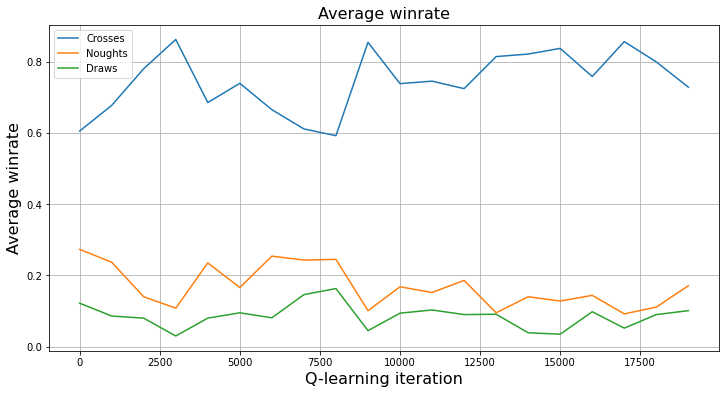

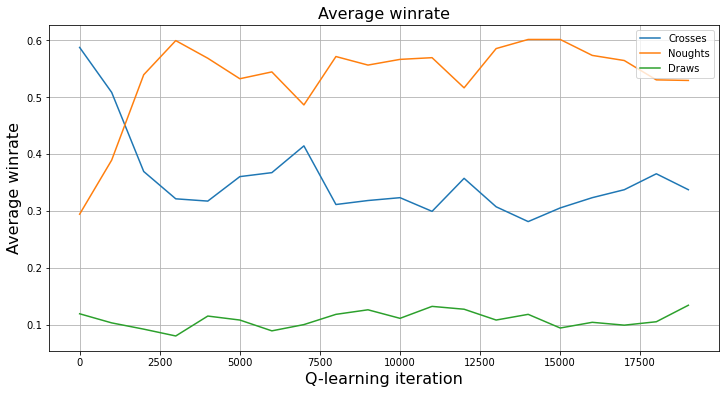

In [12]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)

policies = {1: EpsGreedyPolicy(eps=.1), -1: EpsGreedyPolicy(eps=.1)}

policies, crosses_history, noughts_history = Q_learning(env, policies, verbose=False)

plot_history(crosses_history)
plot_history(noughts_history)

### Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

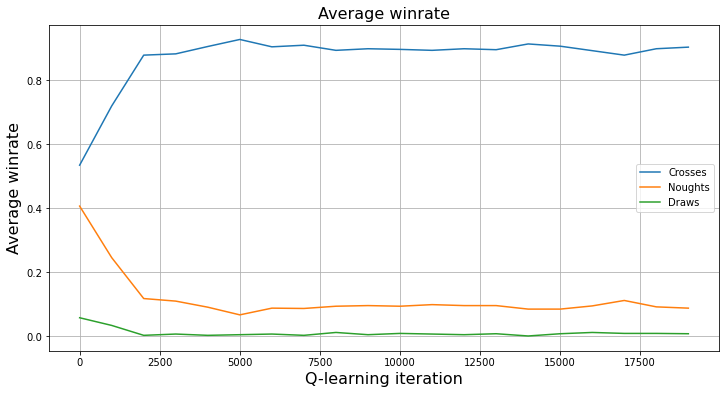

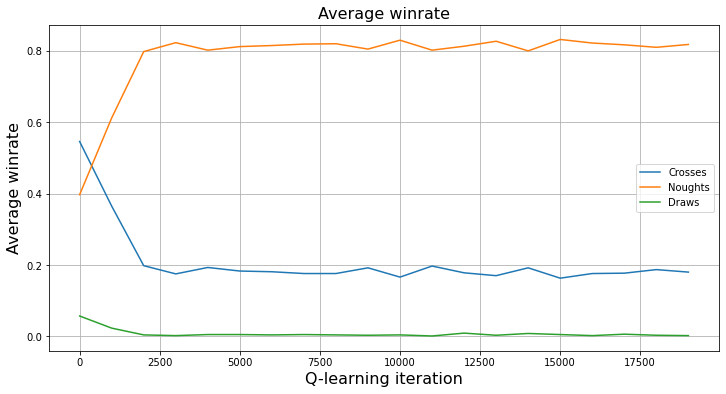

In [13]:
env = TicTacToe(n_rows=5, n_cols=5, n_win=4)

policies = {1: EpsGreedyPolicy(eps=.1), -1: EpsGreedyPolicy(eps=.1)}

policies, crosses_history, noughts_history = Q_learning(env, policies, verbose=False)

plot_history(crosses_history)
plot_history(noughts_history)

## Часть вторая: добавим нейронных сетей
Реализуйте нейронную сеть для метода DQN на доске для крестиков-ноликов. Не буду ограничивать фантазию, но кажется, что свёртки 3х3 здесь должны неплохо работать (в том числе обобщаться на доски размера побольше).  
1. Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.
2. Реализуйте Double DQN и/или Dueling DQN.
